In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import sys
import re
import random
from matplotlib import pyplot as plt
import data
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

stoplist = set(stopwords.words('english'))

authors = data.get_processed_data()

truths = [auth.truth for auth in list(authors.values())]
tweets = [auth.clean for auth in list(authors.values())]

In [168]:
bigrams = []
for user in tweets:
    _bigrams = []
    for tweet in user:
        # tokenized_tweet = word_tokenize(tweet.lower())
        clean_tweet = " ".join([token for token in tweet.split(" ") if token not in stoplist])
        _bigrams += ["_".join(b) for b in list(nltk.bigrams(tweet.split()))]
    _bigrams = " ".join(list(_bigrams))
    bigrams += [_bigrams]
len(bigrams)

300

Searching for fake-news spreaders...
0.7499999999999998
0.44999999999999996
0.6000000000000001
0.4999999999999999
0.7000000000000001
0.6000000000000001
0.6000000000000001
0.6000000000000001
0.6000000000000001
0.6499999999999999
0.7000000000000001
0.6000000000000001


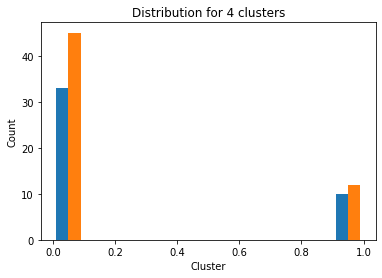

In [169]:
list_of_sets = []

split = 200
tweetsTrain = bigrams[:split]
tweetsTest = bigrams[split:]
true_k = 4

print("Searching for fake-news spreaders...")
notif = False
while len(list_of_sets) < 10:
    
    if (len(list_of_sets) - 1) % 10 == 0 and notif:
        notif == True
    
    if not notif and len(list_of_sets) % 10 == 0 and len(list_of_sets) != 0:
        print(f"Found {len(list_of_sets)} good clusters...")
        notif = True

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(tweetsTrain)
    model = KMeans(n_clusters=true_k, algorithm="full", init='k-means++', max_iter=5000, n_init=4)
    model.fit(X)

    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()

    pred = np.zeros((len(tweetsTest), 2))
    for i, tw in enumerate(tweetsTest):
        X = vectorizer.transform([tw])
        predicted = model.predict(X)
        pred[i] = [int(predicted), truths[i + split]]

    res = [(pred[np.where(pred[:, 1]==k)])[:,0] for k in range(2)]

    max_purity = 0 ; pure_cluster = -1
    for c in range(true_k):
        class_a = len(np.where(res[0]==c)[0])
        class_b = len(np.where(res[1]==c)[0])

        class_sum = class_a + class_b
        if class_sum != 0:
            purity = abs(0.5 - class_a / class_sum) * (class_sum/len(tweetsTest)) * 10
        else:
            purity = 0
        if purity > max_purity:
            pure_cluster = c
            max_purity = purity
    print(max_purity)
    if max_purity >= 0.6:
        list_of_sets += [set()]
        for ind in order_centroids[pure_cluster,:100]:
            list_of_sets[-1].add(terms[ind])

        if (len(list_of_sets) % 10 == 0):
            plt.hist(res)
            plt.title(f"Distribution for {true_k} clusters")
            plt.ylabel("Count")
            plt.xlabel("Cluster")
            plt.savefig(f"reports/figures/prelim/bigram-clusters-{len(list_of_sets)/10}.png")

final_set = list_of_sets[0]
for s in list_of_sets:
    final_set = final_set.intersection(s)

file = open("data/interim/fake-news-most-common-BIGRAMS.txt", "w")
for term in list(final_set):
    file.writelines(term + "\n")
file.close()

300